In [1]:
import numpy as np
print(np.__version__)
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import os

1.21.2


# Get Data

In [2]:
from datasets import LoadDataset, CustomOutput
from datasets.custom_output import image_tensor, float_mask

loaded_data = LoadDataset("_data/preprocessed256", image_dtype=float,
                          label_dtype=float)

dataset = CustomOutput(loaded_data, image_tensor, float_mask)

In [3]:
len(dataset)

6334

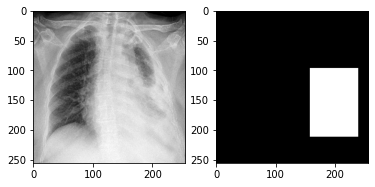

In [4]:
i_img = 42

fig, ax = plt.subplots(1,2)
plt.gray()
ax[0].imshow(dataset[i_img][0][0])
ax[1].imshow(dataset[i_img][1])
plt.show()

In [5]:
dataset[42][1].shape

(256, 256)

In [6]:
# get good split of dataset -> dividable by batch_size
batch_size = 16
l = len(dataset)
x = l // (batch_size *6 )
split = [x * batch_size * 5, l - x * batch_size * 5]
print(split)
train_set, val_set = torch.utils.data.random_split(dataset, split)

[5200, 1134]


In [7]:
dataloader_train = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=0)#, pin_memory = True)
dataloader_val = DataLoader(val_set, batch_size=batch_size,
                        shuffle=True, num_workers=0, pin_memory = True)

# Get Network

In [8]:
from network.unet import Unet

# Get Training

In [9]:
from network.Model import OurModel

In [10]:
import torch.nn as nn
#criterion = nn.CrossEntropyLoss().cuda()
criterion = nn.BCELoss().cuda() # use binary cross entropy loss!
network = Unet()
path = f"./_trainings/{datetime.now().strftime('%d-%m_%H-%M')}"
if os.path.exists(path):
    print("PATH already exists")
else:
    print(f"Make {path} directory")
    os.makedirs(path)

Make ./_trainings/08-09_18-16 directory


In [11]:
Model = OurModel(name = "unet", network= network, criterion= criterion, path_dir = path, lr = 0.001,
                 verbose = True, segmentation=True)
Model.save_configuration()

In [12]:
Model.train(150, dataloader_train, validate = True,
            dataloader_val=dataloader_val, save_observables = True)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

/home/students/patzig/AML_project/.venv/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch1: training_loss = 0.46675741855914776
epoch1: training_dice = 0.3166028878322014


  0%|          | 0/71 [00:00<?, ?it/s]

epoch1: validation_loss = 0.40383236592924093
epoch1: validation_dice = 0.32705601304769516


  0%|          | 0/325 [00:00<?, ?it/s]

epoch2: training_loss = 0.4075111248401495
epoch2: training_dice = 0.32144712975190487


  0%|          | 0/71 [00:00<?, ?it/s]

epoch2: validation_loss = 0.39722342789173126
epoch2: validation_dice = 0.3273072876560856


  0%|          | 0/325 [00:00<?, ?it/s]

epoch3: training_loss = 0.40511086381398714
epoch3: training_dice = 0.3213509760586581


  0%|          | 0/71 [00:00<?, ?it/s]

epoch3: validation_loss = 0.40704013302292624
epoch3: validation_dice = 0.3271815297259411


  0%|          | 0/325 [00:00<?, ?it/s]

epoch4: training_loss = 0.4019580747531011
epoch4: training_dice = 0.32144712885985005


  0%|          | 0/71 [00:00<?, ?it/s]

epoch4: validation_loss = 0.39824760274987825
epoch4: validation_dice = 0.32730713885434914


  0%|          | 0/325 [00:00<?, ?it/s]

epoch5: training_loss = 0.39319696421806627
epoch5: training_dice = 0.32113792944412967


  0%|          | 0/71 [00:00<?, ?it/s]

epoch5: validation_loss = 0.3973855302787163
epoch5: validation_dice = 0.32705564356186023


  0%|          | 0/325 [00:00<?, ?it/s]

epoch6: training_loss = 0.3863012124024905
epoch6: training_dice = 0.3210865857672672


  0%|          | 0/71 [00:00<?, ?it/s]

epoch6: validation_loss = 0.39012311000219535
epoch6: validation_dice = 0.32705569718505295


  0%|          | 0/325 [00:00<?, ?it/s]

epoch7: training_loss = 0.3780404360936238
epoch7: training_dice = 0.30638051212407075


  0%|          | 0/71 [00:00<?, ?it/s]

epoch7: validation_loss = 0.3718282937164038
epoch7: validation_dice = 0.3264113398085178


  0%|          | 0/325 [00:00<?, ?it/s]

epoch8: training_loss = 0.3705684476173841
epoch8: training_dice = 0.28119525510367777


  0%|          | 0/71 [00:00<?, ?it/s]

epoch8: validation_loss = 0.3579745269577268
epoch8: validation_dice = 0.07382890477146901


  0%|          | 0/325 [00:00<?, ?it/s]

epoch9: training_loss = 0.3593026226758957
epoch9: training_dice = 0.191312464701164


  0%|          | 0/71 [00:00<?, ?it/s]

epoch9: validation_loss = 0.36895691739841247
epoch9: validation_dice = 0.24010061388704138


  0%|          | 0/325 [00:00<?, ?it/s]

epoch10: training_loss = 0.35175758095887993
epoch10: training_dice = 0.22786888582202106


  0%|          | 0/71 [00:00<?, ?it/s]

epoch10: validation_loss = 0.33994445435597864
epoch10: validation_dice = 0.1994277041562846


  0%|          | 0/325 [00:00<?, ?it/s]

epoch11: training_loss = 0.3365850416055092
epoch11: training_dice = 0.23069196538283274


  0%|          | 0/71 [00:00<?, ?it/s]

epoch11: validation_loss = 0.3247494025969169
epoch11: validation_dice = 0.22763288398863565


  0%|          | 0/325 [00:00<?, ?it/s]

epoch12: training_loss = 0.32953698080319627
epoch12: training_dice = 0.25076310421411807


  0%|          | 0/71 [00:00<?, ?it/s]

epoch12: validation_loss = 0.3201944374702346
epoch12: validation_dice = 0.23329355819544323


  0%|          | 0/325 [00:00<?, ?it/s]

epoch13: training_loss = 0.3218664550322753
epoch13: training_dice = 0.27139239201178916


  0%|          | 0/71 [00:00<?, ?it/s]

epoch13: validation_loss = 0.3094882175955974
epoch13: validation_dice = 0.313264985004781


  0%|          | 0/325 [00:00<?, ?it/s]

epoch14: training_loss = 0.31406391854469595
epoch14: training_dice = 0.2994533235980914


  0%|          | 0/71 [00:00<?, ?it/s]

epoch14: validation_loss = 0.3285142460339506
epoch14: validation_dice = 0.33869799132078465


  0%|          | 0/325 [00:00<?, ?it/s]

epoch15: training_loss = 0.30804033476572773
epoch15: training_dice = 0.31643678878362363


  0%|          | 0/71 [00:00<?, ?it/s]

epoch15: validation_loss = 0.3162092967352397
epoch15: validation_dice = 0.31129194544234745


  0%|          | 0/325 [00:00<?, ?it/s]

epoch16: training_loss = 0.30567686887887807
epoch16: training_dice = 0.32370508136657566


  0%|          | 0/71 [00:00<?, ?it/s]

epoch16: validation_loss = 0.3141530920082415
epoch16: validation_dice = 0.3555245710090852


  0%|          | 0/325 [00:00<?, ?it/s]

epoch17: training_loss = 0.30002365726691027
epoch17: training_dice = 0.3366341585723253


  0%|          | 0/71 [00:00<?, ?it/s]

epoch17: validation_loss = 0.2972678796086513
epoch17: validation_dice = 0.36364752683841006


  0%|          | 0/325 [00:00<?, ?it/s]

epoch18: training_loss = 0.2941850228034533
epoch18: training_dice = 0.351914347914549


  0%|          | 0/71 [00:00<?, ?it/s]

epoch18: validation_loss = 0.3281348549144369
epoch18: validation_dice = 0.38495912854100617


  0%|          | 0/325 [00:00<?, ?it/s]

epoch19: training_loss = 0.29334744109557226
epoch19: training_dice = 0.35645889426653204


  0%|          | 0/71 [00:00<?, ?it/s]

epoch19: validation_loss = 0.28740527806147725
epoch19: validation_dice = 0.3584063260907858


  0%|          | 0/325 [00:00<?, ?it/s]

epoch20: training_loss = 0.28711332133183115
epoch20: training_dice = 0.3663812908759484


  0%|          | 0/71 [00:00<?, ?it/s]

epoch20: validation_loss = 0.3288759931292332
epoch20: validation_dice = 0.3854746552000583


  0%|          | 0/325 [00:00<?, ?it/s]

epoch21: training_loss = 0.2862411774580295
epoch21: training_dice = 0.3778608104357353


  0%|          | 0/71 [00:00<?, ?it/s]

epoch21: validation_loss = 0.28259588295305277
epoch21: validation_dice = 0.3536139837872814


  0%|          | 0/325 [00:00<?, ?it/s]

epoch22: training_loss = 0.28459387183189394
epoch22: training_dice = 0.37512327084174524


  0%|          | 0/71 [00:00<?, ?it/s]

epoch22: validation_loss = 0.2888689106199103
epoch22: validation_dice = 0.3518265406010856


  0%|          | 0/325 [00:00<?, ?it/s]

epoch23: training_loss = 0.278458976149559
epoch23: training_dice = 0.380935997733703


  0%|          | 0/71 [00:00<?, ?it/s]

epoch23: validation_loss = 0.29794201212869564
epoch23: validation_dice = 0.36054002504113697


  0%|          | 0/325 [00:00<?, ?it/s]

epoch24: training_loss = 0.27661985291884494
epoch24: training_dice = 0.3843827141248263


  0%|          | 0/71 [00:00<?, ?it/s]

epoch24: validation_loss = 0.28713410400169
epoch24: validation_dice = 0.3467152416706085


  0%|          | 0/325 [00:00<?, ?it/s]

epoch25: training_loss = 0.2718728530406952
epoch25: training_dice = 0.3914442119231591


  0%|          | 0/71 [00:00<?, ?it/s]

epoch25: validation_loss = 0.2893616259098053
epoch25: validation_dice = 0.3664243225480469


  0%|          | 0/325 [00:00<?, ?it/s]

epoch26: training_loss = 0.2662875121831894
epoch26: training_dice = 0.39950072614046245


  0%|          | 0/71 [00:00<?, ?it/s]

epoch26: validation_loss = 0.2898949216788923
epoch26: validation_dice = 0.361844540062085


  0%|          | 0/325 [00:00<?, ?it/s]

epoch27: training_loss = 0.26164233702879686
epoch27: training_dice = 0.40645195089853725


  0%|          | 0/71 [00:00<?, ?it/s]

epoch27: validation_loss = 0.28927318814774633
epoch27: validation_dice = 0.37427102386111943


  0%|          | 0/325 [00:00<?, ?it/s]

epoch28: training_loss = 0.2556890160762347
epoch28: training_dice = 0.4142811793088913


  0%|          | 0/71 [00:00<?, ?it/s]

epoch28: validation_loss = 0.28588555648293296
epoch28: validation_dice = 0.35890082993977507


  0%|          | 0/325 [00:00<?, ?it/s]

epoch29: training_loss = 0.25206799323742207
epoch29: training_dice = 0.4203502643108368


  0%|          | 0/71 [00:00<?, ?it/s]

epoch29: validation_loss = 0.29643076259485435
epoch29: validation_dice = 0.3540333910307414


  0%|          | 0/325 [00:00<?, ?it/s]

epoch30: training_loss = 0.24537753669115214
epoch30: training_dice = 0.42718983283409706


  0%|          | 0/71 [00:00<?, ?it/s]

epoch30: validation_loss = 0.28881610929965973
epoch30: validation_dice = 0.35271766571931434


  0%|          | 0/325 [00:00<?, ?it/s]

epoch31: training_loss = 0.2380796517775609
epoch31: training_dice = 0.4358546204291857


  0%|          | 0/71 [00:00<?, ?it/s]

epoch31: validation_loss = 0.31674658937353484
epoch31: validation_dice = 0.3406975862215942


  0%|          | 0/325 [00:00<?, ?it/s]

epoch32: training_loss = 0.22989262101741936
epoch32: training_dice = 0.44050211649674637


  0%|          | 0/71 [00:00<?, ?it/s]

epoch32: validation_loss = 0.30134748258221317
epoch32: validation_dice = 0.35023624061698644


  0%|          | 0/325 [00:00<?, ?it/s]

epoch33: training_loss = 0.22137601412259617
epoch33: training_dice = 0.450765850177178


  0%|          | 0/71 [00:00<?, ?it/s]

epoch33: validation_loss = 0.3150607229958118
epoch33: validation_dice = 0.3579428126694451


  0%|          | 0/325 [00:00<?, ?it/s]

epoch34: training_loss = 0.2099036591557356
epoch34: training_dice = 0.4661327607356585


  0%|          | 0/71 [00:00<?, ?it/s]

epoch34: validation_loss = 0.3166146481960592
epoch34: validation_dice = 0.3391391800742754


  0%|          | 0/325 [00:00<?, ?it/s]

epoch35: training_loss = 0.2036041726745092
epoch35: training_dice = 0.47368930770800666


  0%|          | 0/71 [00:00<?, ?it/s]

epoch35: validation_loss = 0.32133277495142437
epoch35: validation_dice = 0.3478020721338165


  0%|          | 0/325 [00:00<?, ?it/s]

epoch36: training_loss = 0.19237201585219457
epoch36: training_dice = 0.4867448149736111


  0%|          | 0/71 [00:00<?, ?it/s]

epoch36: validation_loss = 0.34519613061992216
epoch36: validation_dice = 0.32398644362536955


  0%|          | 0/325 [00:00<?, ?it/s]

epoch37: training_loss = 0.18035400285170627
epoch37: training_dice = 0.498585346020185


  0%|          | 0/71 [00:00<?, ?it/s]

epoch37: validation_loss = 0.33664332372202
epoch37: validation_dice = 0.33609993105203334


  0%|          | 0/325 [00:00<?, ?it/s]

epoch38: training_loss = 0.17027291637200576
epoch38: training_dice = 0.5122265898264371


  0%|          | 0/71 [00:00<?, ?it/s]

epoch38: validation_loss = 0.371582170817214
epoch38: validation_dice = 0.31631388861528587


  0%|          | 0/325 [00:00<?, ?it/s]

epoch39: training_loss = 0.16043988672586587
epoch39: training_dice = 0.5226265541406778


  0%|          | 0/71 [00:00<?, ?it/s]

epoch39: validation_loss = 0.39273503065948756
epoch39: validation_dice = 0.2904468218625431


  0%|          | 0/325 [00:00<?, ?it/s]

epoch40: training_loss = 0.15013150228903843
epoch40: training_dice = 0.5366553666958442


  0%|          | 0/71 [00:00<?, ?it/s]

epoch40: validation_loss = 0.4120541622101421
epoch40: validation_dice = 0.31929882752223754


  0%|          | 0/325 [00:00<?, ?it/s]

epoch41: training_loss = 0.14176695289520116
epoch41: training_dice = 0.5443762406936059


  0%|          | 0/71 [00:00<?, ?it/s]

epoch41: validation_loss = 0.4116907562588302
epoch41: validation_dice = 0.3048982498511462


  0%|          | 0/325 [00:00<?, ?it/s]

epoch42: training_loss = 0.1384232839024984
epoch42: training_dice = 0.5504418249313648


  0%|          | 0/71 [00:00<?, ?it/s]

epoch42: validation_loss = 0.4430482202852276
epoch42: validation_dice = 0.305535979254145


  0%|          | 0/325 [00:00<?, ?it/s]

epoch43: training_loss = 0.1266374029792272
epoch43: training_dice = 0.5646320433800037


  0%|          | 0/71 [00:00<?, ?it/s]

epoch43: validation_loss = 0.4518664966166859
epoch43: validation_dice = 0.3151909094041502


  0%|          | 0/325 [00:00<?, ?it/s]

epoch44: training_loss = 0.1213568906715283
epoch44: training_dice = 0.5737238652889545


  0%|          | 0/71 [00:00<?, ?it/s]

epoch44: validation_loss = 0.45561454623517855
epoch44: validation_dice = 0.32693654634583164


  0%|          | 0/325 [00:00<?, ?it/s]

epoch45: training_loss = 0.1141777007167156
epoch45: training_dice = 0.5823390788298387


  0%|          | 0/71 [00:00<?, ?it/s]

epoch45: validation_loss = 0.487999312054943
epoch45: validation_dice = 0.3148287910390908


  0%|          | 0/325 [00:00<?, ?it/s]

epoch46: training_loss = 0.10566138659532254
epoch46: training_dice = 0.5930676045784583


  0%|          | 0/71 [00:00<?, ?it/s]

epoch46: validation_loss = 0.5188927931684844
epoch46: validation_dice = 0.33734132937142547


  0%|          | 0/325 [00:00<?, ?it/s]

epoch47: training_loss = 0.10177913865217796
epoch47: training_dice = 0.5947677207910097


  0%|          | 0/71 [00:00<?, ?it/s]

epoch47: validation_loss = 0.49036190711276634
epoch47: validation_dice = 0.33065624094345203


  0%|          | 0/325 [00:00<?, ?it/s]

epoch48: training_loss = 0.1017654316012676
epoch48: training_dice = 0.5925837522286636


  0%|          | 0/71 [00:00<?, ?it/s]

epoch48: validation_loss = 0.44462878519380594
epoch48: validation_dice = 0.298330994978757


  0%|          | 0/325 [00:00<?, ?it/s]

epoch49: training_loss = 0.09176205061949216
epoch49: training_dice = 0.6092000668782455


  0%|          | 0/71 [00:00<?, ?it/s]

epoch49: validation_loss = 0.4517191980086582
epoch49: validation_dice = 0.3210835314132798


  0%|          | 0/325 [00:00<?, ?it/s]

epoch50: training_loss = 0.09238700397885763
epoch50: training_dice = 0.6060632654795279


  0%|          | 0/71 [00:00<?, ?it/s]

epoch50: validation_loss = 0.6111109777235649
epoch50: validation_dice = 0.2844134401267683


  0%|          | 0/325 [00:00<?, ?it/s]

epoch51: training_loss = 0.082725934111155
epoch51: training_dice = 0.6210895882203029


  0%|          | 0/71 [00:00<?, ?it/s]

epoch51: validation_loss = 0.5395134737793829
epoch51: validation_dice = 0.3275363955279471


  0%|          | 0/325 [00:00<?, ?it/s]

epoch52: training_loss = 0.08397080279313601
epoch52: training_dice = 0.6217792994242448


  0%|          | 0/71 [00:00<?, ?it/s]

epoch52: validation_loss = 0.49966669292517113
epoch52: validation_dice = 0.2915846046427606


  0%|          | 0/325 [00:00<?, ?it/s]

epoch53: training_loss = 0.08180713529770191
epoch53: training_dice = 0.6187335190406212


  0%|          | 0/71 [00:00<?, ?it/s]

epoch53: validation_loss = 0.6085376815057136
epoch53: validation_dice = 0.3213000769766284


  0%|          | 0/325 [00:00<?, ?it/s]

epoch54: training_loss = 0.07293193504214286
epoch54: training_dice = 0.6331144491525796


  0%|          | 0/71 [00:00<?, ?it/s]

epoch54: validation_loss = 0.6082317640244121
epoch54: validation_dice = 0.30649377426631014


  0%|          | 0/325 [00:00<?, ?it/s]

epoch55: training_loss = 0.07324742442140213
epoch55: training_dice = 0.6298657538340642


  0%|          | 0/71 [00:00<?, ?it/s]

epoch55: validation_loss = 0.6282085725958918
epoch55: validation_dice = 0.30692521094436376


  0%|          | 0/325 [00:00<?, ?it/s]

epoch56: training_loss = 0.06955099042791586
epoch56: training_dice = 0.6324885075825911


  0%|          | 0/71 [00:00<?, ?it/s]

epoch56: validation_loss = 0.7014805787885693
epoch56: validation_dice = 0.3029079298738023


  0%|          | 0/325 [00:00<?, ?it/s]

epoch57: training_loss = 0.0653213828859421
epoch57: training_dice = 0.640839707668011


  0%|          | 0/71 [00:00<?, ?it/s]

epoch57: validation_loss = 0.5310930718838329
epoch57: validation_dice = 0.3330446343186875


  0%|          | 0/325 [00:00<?, ?it/s]

epoch58: training_loss = 0.06573476556401986
epoch58: training_dice = 0.6377031865486732


  0%|          | 0/71 [00:00<?, ?it/s]

epoch58: validation_loss = 0.6535298715175037
epoch58: validation_dice = 0.32033521818443084


  0%|          | 0/325 [00:00<?, ?it/s]

epoch59: training_loss = 0.06052035294473171
epoch59: training_dice = 0.6471879528119013


  0%|          | 0/71 [00:00<?, ?it/s]

epoch59: validation_loss = 0.7278364674306251
epoch59: validation_dice = 0.3219669198905918


  0%|          | 0/325 [00:00<?, ?it/s]

epoch60: training_loss = 0.06144362462254671
epoch60: training_dice = 0.644062477350235


  0%|          | 0/71 [00:00<?, ?it/s]

epoch60: validation_loss = 0.7996931785429028
epoch60: validation_dice = 0.31655581337465366


  0%|          | 0/325 [00:00<?, ?it/s]

epoch61: training_loss = 0.05470277726077116
epoch61: training_dice = 0.6568972539901733


  0%|          | 0/71 [00:00<?, ?it/s]

epoch61: validation_loss = 0.7180734986150769
epoch61: validation_dice = 0.3145174875225819


  0%|          | 0/325 [00:00<?, ?it/s]

epoch62: training_loss = 0.0566225172407352
epoch62: training_dice = 0.6542459591535421


  0%|          | 0/71 [00:00<?, ?it/s]

epoch62: validation_loss = 0.7697118256293553
epoch62: validation_dice = 0.32074849223586877


  0%|          | 0/325 [00:00<?, ?it/s]

epoch63: training_loss = 0.05346056417203866
epoch63: training_dice = 0.6523562257106488


  0%|          | 0/71 [00:00<?, ?it/s]

epoch63: validation_loss = 0.7539913637537352
epoch63: validation_dice = 0.31049940262881803


  0%|          | 0/325 [00:00<?, ?it/s]

epoch64: training_loss = 0.0541916883794161
epoch64: training_dice = 0.6549973516280835


  0%|          | 0/71 [00:00<?, ?it/s]

epoch64: validation_loss = 0.6524568905293102
epoch64: validation_dice = 0.3000772255407253


  0%|          | 0/325 [00:00<?, ?it/s]

epoch65: training_loss = 0.05067055875292191
epoch65: training_dice = 0.6600964062947493


  0%|          | 0/71 [00:00<?, ?it/s]

epoch65: validation_loss = 0.8379794909080989
epoch65: validation_dice = 0.32246972746412517


  0%|          | 0/325 [00:00<?, ?it/s]

epoch66: training_loss = 0.04831831771593827
epoch66: training_dice = 0.6683250299783854


  0%|          | 0/71 [00:00<?, ?it/s]

epoch66: validation_loss = 0.8197042031187407
epoch66: validation_dice = 0.30246912425672506


  0%|          | 0/325 [00:00<?, ?it/s]

epoch67: training_loss = 0.049306497550927676
epoch67: training_dice = 0.6636977048103626


  0%|          | 0/71 [00:00<?, ?it/s]

epoch67: validation_loss = 0.8568263011918941
epoch67: validation_dice = 0.3167827838743237


  0%|          | 0/325 [00:00<?, ?it/s]

epoch68: training_loss = 0.04458135146361131
epoch68: training_dice = 0.6751198306450477


  0%|          | 0/71 [00:00<?, ?it/s]

epoch68: validation_loss = 0.8447856055179113
epoch68: validation_dice = 0.31159706938434656


  0%|          | 0/325 [00:00<?, ?it/s]

epoch69: training_loss = 0.04814432436457047
epoch69: training_dice = 0.6642659005751976


  0%|          | 0/71 [00:00<?, ?it/s]

epoch69: validation_loss = 0.9273218462164973
epoch69: validation_dice = 0.32261767164922095


  0%|          | 0/325 [00:00<?, ?it/s]

epoch70: training_loss = 0.043513199366056
epoch70: training_dice = 0.6725798355616056


  0%|          | 0/71 [00:00<?, ?it/s]

epoch70: validation_loss = 0.8551321021268066
epoch70: validation_dice = 0.32375377101797453


  0%|          | 0/325 [00:00<?, ?it/s]

epoch71: training_loss = 0.048416703475209384
epoch71: training_dice = 0.657891164284486


  0%|          | 0/71 [00:00<?, ?it/s]

epoch71: validation_loss = 0.7196341857943737
epoch71: validation_dice = 0.3110835149254597


  0%|          | 0/325 [00:00<?, ?it/s]

epoch72: training_loss = 0.04128097269970637
epoch72: training_dice = 0.674520946924503


  0%|          | 0/71 [00:00<?, ?it/s]

epoch72: validation_loss = 0.8476239904551439
epoch72: validation_dice = 0.3225188977281812


  0%|          | 0/325 [00:00<?, ?it/s]

epoch73: training_loss = 0.04139210310692971
epoch73: training_dice = 0.6788341716619638


  0%|          | 0/71 [00:00<?, ?it/s]

epoch73: validation_loss = 0.7708850981483997
epoch73: validation_dice = 0.32132152205621695


  0%|          | 0/325 [00:00<?, ?it/s]

epoch74: training_loss = 0.041123067937218226
epoch74: training_dice = 0.6718447937415196


  0%|          | 0/71 [00:00<?, ?it/s]

epoch74: validation_loss = 0.8453595948890901
epoch74: validation_dice = 0.3131300317989269


  0%|          | 0/325 [00:00<?, ?it/s]

epoch75: training_loss = 0.037718379044762024
epoch75: training_dice = 0.6876282281142014


  0%|          | 0/71 [00:00<?, ?it/s]

epoch75: validation_loss = 0.8650449799819732
epoch75: validation_dice = 0.31342592310737555


  0%|          | 0/325 [00:00<?, ?it/s]

epoch76: training_loss = 0.03579983013753708
epoch76: training_dice = 0.6898482877474564


  0%|          | 0/71 [00:00<?, ?it/s]

epoch76: validation_loss = 1.0102031205741453
epoch76: validation_dice = 0.297960801233708


  0%|          | 0/325 [00:00<?, ?it/s]

epoch77: training_loss = 0.041387746308285456
epoch77: training_dice = 0.6800630022929265


  0%|          | 0/71 [00:00<?, ?it/s]

epoch77: validation_loss = 0.8003270957671421
epoch77: validation_dice = 0.30187337415319093


  0%|          | 0/325 [00:00<?, ?it/s]

epoch78: training_loss = 0.038684344675678474
epoch78: training_dice = 0.6796281477121207


  0%|          | 0/71 [00:00<?, ?it/s]

epoch78: validation_loss = 0.8515192312254033
epoch78: validation_dice = 0.2946631996564462


  0%|          | 0/325 [00:00<?, ?it/s]

epoch79: training_loss = 0.03750430357284271
epoch79: training_dice = 0.683656832071451


  0%|          | 0/71 [00:00<?, ?it/s]

epoch79: validation_loss = 0.9327566397022193
epoch79: validation_dice = 0.3125206792438534


  0%|          | 0/325 [00:00<?, ?it/s]

epoch80: training_loss = 0.033148296005450766
epoch80: training_dice = 0.6966915921981518


  0%|          | 0/71 [00:00<?, ?it/s]

epoch80: validation_loss = 0.84850002552422
epoch80: validation_dice = 0.32296609605701876


  0%|          | 0/325 [00:00<?, ?it/s]

epoch81: training_loss = 0.04713910352152127
epoch81: training_dice = 0.6630608998812162


  0%|          | 0/71 [00:00<?, ?it/s]

epoch81: validation_loss = 0.9043314238669167
epoch81: validation_dice = 0.32765270874533853


  0%|          | 0/325 [00:00<?, ?it/s]

epoch82: training_loss = 0.03397638989182619
epoch82: training_dice = 0.6950476532716018


  0%|          | 0/71 [00:00<?, ?it/s]

epoch82: validation_loss = 1.1152726365646846
epoch82: validation_dice = 0.31399027436551913


  0%|          | 0/325 [00:00<?, ?it/s]

epoch83: training_loss = 0.028135685476546105
epoch83: training_dice = 0.7186404488636897


  0%|          | 0/71 [00:00<?, ?it/s]

epoch83: validation_loss = 1.1557504988052476
epoch83: validation_dice = 0.3060099879201029


  0%|          | 0/325 [00:00<?, ?it/s]

epoch84: training_loss = 0.03908338966851051
epoch84: training_dice = 0.6824758626864507


  0%|          | 0/71 [00:00<?, ?it/s]

epoch84: validation_loss = 0.8826990043613273
epoch84: validation_dice = 0.31985018853570374


  0%|          | 0/325 [00:00<?, ?it/s]

epoch85: training_loss = 0.03110861128912522
epoch85: training_dice = 0.6987993045953604


  0%|          | 0/71 [00:00<?, ?it/s]

epoch85: validation_loss = 1.1725128695998392
epoch85: validation_dice = 0.3288058103390143


  0%|          | 0/325 [00:00<?, ?it/s]

epoch86: training_loss = 0.03020400829613209
epoch86: training_dice = 0.7043900125760298


  0%|          | 0/71 [00:00<?, ?it/s]

epoch86: validation_loss = 1.0549601408797251
epoch86: validation_dice = 0.3202896258780654


  0%|          | 0/325 [00:00<?, ?it/s]

epoch87: training_loss = 0.030650284344760272
epoch87: training_dice = 0.7025762429604163


  0%|          | 0/71 [00:00<?, ?it/s]

epoch87: validation_loss = 1.2262725981188491
epoch87: validation_dice = 0.31748454566572754


  0%|          | 0/325 [00:00<?, ?it/s]

epoch88: training_loss = 0.030028418887120028
epoch88: training_dice = 0.7068320378890405


  0%|          | 0/71 [00:00<?, ?it/s]

epoch88: validation_loss = 0.5543657532880004
epoch88: validation_dice = 0.33140699523435513


  0%|          | 0/325 [00:00<?, ?it/s]

epoch89: training_loss = 0.045523092723809756
epoch89: training_dice = 0.6598665176905119


  0%|          | 0/71 [00:00<?, ?it/s]

epoch89: validation_loss = 0.961502194404602
epoch89: validation_dice = 0.3124933889214422


  0%|          | 0/325 [00:00<?, ?it/s]

epoch90: training_loss = 0.036919459657600295
epoch90: training_dice = 0.6875822565188775


  0%|          | 0/71 [00:00<?, ?it/s]

epoch90: validation_loss = 0.8464394937938368
epoch90: validation_dice = 0.3028671764571902


  0%|          | 0/325 [00:00<?, ?it/s]

epoch91: training_loss = 0.02871335218445613
epoch91: training_dice = 0.7038565162511973


  0%|          | 0/71 [00:00<?, ?it/s]

epoch91: validation_loss = 1.1833782103699697
epoch91: validation_dice = 0.2992253517600852


  0%|          | 0/325 [00:00<?, ?it/s]

epoch92: training_loss = 0.026741348917667683
epoch92: training_dice = 0.7225954373066242


  0%|          | 0/71 [00:00<?, ?it/s]

epoch92: validation_loss = 1.0912010124031926
epoch92: validation_dice = 0.3076370429824775


  0%|          | 0/325 [00:00<?, ?it/s]

epoch93: training_loss = 0.029331268656712314
epoch93: training_dice = 0.7042425371133364


  0%|          | 0/71 [00:00<?, ?it/s]

epoch93: validation_loss = 0.9404690681209027
epoch93: validation_dice = 0.3136105029515817


  0%|          | 0/325 [00:00<?, ?it/s]

epoch94: training_loss = 0.03171466168016195
epoch94: training_dice = 0.7042631717828604


  0%|          | 0/71 [00:00<?, ?it/s]

epoch94: validation_loss = 1.1243204340128832
epoch94: validation_dice = 0.30651135029087606


  0%|          | 0/325 [00:00<?, ?it/s]

epoch95: training_loss = 0.0318804442223448
epoch95: training_dice = 0.6949910920399885


  0%|          | 0/71 [00:00<?, ?it/s]

epoch95: validation_loss = 1.2383635841624838
epoch95: validation_dice = 0.31901357753176085


  0%|          | 0/325 [00:00<?, ?it/s]

epoch96: training_loss = 0.025968670584261416
epoch96: training_dice = 0.7207555117973915


  0%|          | 0/71 [00:00<?, ?it/s]

epoch96: validation_loss = 1.014739005498483
epoch96: validation_dice = 0.3218104908583869


  0%|          | 0/325 [00:00<?, ?it/s]

epoch97: training_loss = 0.025990476791675276
epoch97: training_dice = 0.7191972885682033


  0%|          | 0/71 [00:00<?, ?it/s]

epoch97: validation_loss = 1.272280515919269
epoch97: validation_dice = 0.3147040156411453


  0%|          | 0/325 [00:00<?, ?it/s]

epoch98: training_loss = 0.03848933099840696
epoch98: training_dice = 0.6818701484570137


  0%|          | 0/71 [00:00<?, ?it/s]

epoch98: validation_loss = 1.0468917623372145
epoch98: validation_dice = 0.32037979826121266


  0%|          | 0/325 [00:00<?, ?it/s]

epoch99: training_loss = 0.029158948914935957
epoch99: training_dice = 0.706711153800671


  0%|          | 0/71 [00:00<?, ?it/s]

epoch99: validation_loss = 0.9825987421290975
epoch99: validation_dice = 0.3137582611869758


  0%|          | 0/325 [00:00<?, ?it/s]

epoch100: training_loss = 0.023858224732371477
epoch100: training_dice = 0.7308009073367485


  0%|          | 0/71 [00:00<?, ?it/s]

epoch100: validation_loss = 1.221157215850454
epoch100: validation_dice = 0.30993977839678105


  0%|          | 0/325 [00:00<?, ?it/s]

epoch101: training_loss = 0.021351961900408452
epoch101: training_dice = 0.7436571452250847


  0%|          | 0/71 [00:00<?, ?it/s]

epoch101: validation_loss = 1.1585909564730148
epoch101: validation_dice = 0.3192335463745493


  0%|          | 0/325 [00:00<?, ?it/s]

epoch102: training_loss = 0.033307854301081255
epoch102: training_dice = 0.6886999486042903


  0%|          | 0/71 [00:00<?, ?it/s]

epoch102: validation_loss = 0.7312784274698982
epoch102: validation_dice = 0.30859045516437206


  0%|          | 0/325 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#Model.load_weights(f"/Unet_first_try_e50.ckpt")

In [ ]:
"""for x,y in dataloader_val:
    Model.network.eval()
    y_hat = Model.network(x.float().cuda())
    break

y_hat = y_hat.cpu()
y_hat = y_hat.detach().numpy()
y = y.numpy()
fig, ax = plt.subplots(len(y_hat),3, figsize=(10, 100))
for i in range(len(y_hat)):
    ax[i,0].imshow(y_hat[i])
    ax[i,1].imshow(np.round(y_hat[i]))
    ax[i,2].imshow(y[i])"""